# 03 - Model Training

Train and evaluate three baseline classification models for personal loan approval prediction.

**Models:**
1. Logistic Regression
2. Random Forest
3. Artificial Neural Network (MLPClassifier)

**Objectives:**
- Establish baseline performance with default hyperparameters
- Evaluate using cross-validation and held-out test set
- Compare models using multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
- Prepare recommendations for Phase 4 (hyperparameter optimization)

**Note:** For detailed explanation of preprocessing steps, see `02_feature_engineering.ipynb`.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# SMOTE for class balancing
from imblearn.over_sampling import SMOTE

# Settings
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Project paths
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data" / "Dataset - 2526.csv"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"
FIGURES_DIR = RESULTS_DIR / "figures"

# Ensure directories exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Universal random state for reproducibility
RANDOM_STATE = 38

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")


Project root: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models
Data path: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/data/Dataset - 2526.csv


## 1. Data Preprocessing Pipeline

Condensed preprocessing from Phase 2. This cell reproduces the exact transformations applied in `02_feature_engineering.ipynb` to ensure consistency.


In [2]:
# Load raw data
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")

# --- Outlier capping ---
df['person_age'] = df['person_age'].clip(upper=100)
df['person_income'] = df['person_income'].clip(upper=df['person_income'].quantile(0.99))
df['person_emp_exp'] = df['person_emp_exp'].clip(upper=df['person_emp_exp'].quantile(0.99))
df['loan_amnt'] = df['loan_amnt'].clip(upper=df['loan_amnt'].quantile(0.99))

# --- Categorical encoding ---
df['person_gender'] = LabelEncoder().fit_transform(df['person_gender'])
df['previous_loan_defaults_on_file'] = LabelEncoder().fit_transform(df['previous_loan_defaults_on_file'])
df['person_education'] = df['person_education'].map({
    'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4
})
df['person_home_ownership'] = LabelEncoder().fit_transform(df['person_home_ownership'])
df['loan_intent'] = LabelEncoder().fit_transform(df['loan_intent'])

# --- Feature engineering ---
df['log_income'] = np.log1p(df['person_income'])
df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
df['income_per_household'] = df['person_income'] / df['ppl_household'].clip(lower=1)
df['credit_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

# --- Prepare features and target ---
X = df.drop(columns=['loan_status'])
y = df['loan_status']
feature_names = X.columns.tolist()

print(f"\nFeatures: {len(feature_names)} columns")
print(f"Target distribution: {y.value_counts().to_dict()}")


Loaded dataset: 45,000 rows x 16 columns

Features: 19 columns
Target distribution: {0: 35000, 1: 10000}


In [3]:
# --- Train-test split (80/20, stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# --- Feature scaling ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=feature_names, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=feature_names, 
    index=X_test.index
)

# Keep unscaled versions for Random Forest
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

# --- SMOTE oversampling (training data only) ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_train_unscaled_res, _ = smote.fit_resample(X_train_unscaled, y_train)

print("=" * 50)
print("DATA READY FOR TRAINING")
print("=" * 50)
print(f"\nTraining set (after SMOTE):")
print(f"  X_train_scaled_res: {X_train_scaled_res.shape}")
print(f"  X_train_unscaled_res: {X_train_unscaled_res.shape}")
print(f"  y_train_res: {pd.Series(y_train_res).value_counts().to_dict()}")
print(f"\nTest set (original distribution):")
print(f"  X_test_scaled: {X_test_scaled.shape}")
print(f"  X_test_unscaled: {X_test_unscaled.shape}")
print(f"  y_test: {y_test.value_counts().to_dict()}")


DATA READY FOR TRAINING

Training set (after SMOTE):
  X_train_scaled_res: (56000, 19)
  X_train_unscaled_res: (56000, 19)
  y_train_res: {0: 28000, 1: 28000}

Test set (original distribution):
  X_test_scaled: (9000, 19)
  X_test_unscaled: (9000, 19)
  y_test: {0: 7000, 1: 2000}


## 2. Evaluation Framework

Define reusable functions for model evaluation:
- **Cross-validation:** 5-fold stratified CV for robust performance estimates
- **Test evaluation:** Full metrics on held-out test set
- **Visualizations:** Confusion matrices and ROC curves

### Metrics Used:
- **Accuracy:** Overall correctness (may be misleading with imbalanced data)
- **Precision:** Of predicted approvals, how many are correct?
- **Recall:** Of actual approvals, how many did we identify?
- **F1-Score:** Harmonic mean of precision and recall
- **ROC-AUC:** Model's ability to discriminate between classes


In [19]:
def cross_validate_model(model, X, y, cv=5):
    """
    Perform stratified k-fold cross-validation and return metrics.
    
    Returns dict with mean and std for each metric.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Cross-validation scores for multiple metrics
    scoring_metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    results = {}
    for name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X, y, cv=skf, scoring=scorer)
        results[f'{name}_mean'] = scores.mean()
        results[f'{name}_std'] = scores.std()
    
    return results


def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model on test data.
    
    Returns dict with all metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_true, y_pred, model_name, ax=None):
    """
    Plot confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} - Confusion Matrix')
    
    return ax


def print_cv_results(results, model_name):
    """Print formatted cross-validation results."""
    print(f"\n{'='*50}")
    print(f"{model_name} - Cross-Validation Results (5-fold)")
    print('='*50)
    print(f"  Accuracy:  {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
    print(f"  Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
    print(f"  Recall:    {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
    print(f"  F1-Score:  {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
    print(f"  ROC-AUC:   {results['roc_auc_mean']:.4f} ± {results['roc_auc_std']:.4f}")


def print_test_results(metrics, y_test, y_pred):
    """Print formatted test set evaluation results."""
    print(f"\n{'='*50}")
    print(f"{metrics['model']} - Test Set Results")
    print('='*50)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))
    print(f"ROC-AUC Score: {metrics['roc_auc']:.4f}")


print("Evaluation functions defined successfully.")


Evaluation functions defined successfully.


## 3. Logistic Regression

A linear model that estimates the probability of loan approval using a logistic function. 

**Characteristics:**
- Interpretable coefficients
- Fast training and prediction
- Works best when relationships are approximately linear
- Requires scaled features for optimal convergence

**Data Used:** Scaled training data (`X_train_scaled_res`)


In [5]:
# Initialize Logistic Regression with default parameters
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Cross-validation on training data
print("Running 5-fold cross-validation...")
lr_cv_results = cross_validate_model(lr_model, X_train_scaled_res, y_train_res)
print_cv_results(lr_cv_results, "Logistic Regression")

# Train on full training set
lr_model.fit(X_train_scaled_res, y_train_res)
print("\nModel trained on full training set.")


Running 5-fold cross-validation...

Logistic Regression - Cross-Validation Results (5-fold)
  Accuracy:  0.8863 ± 0.0036
  Precision: 0.8590 ± 0.0031
  Recall:    0.9244 ± 0.0072
  F1-Score:  0.8905 ± 0.0038
  ROC-AUC:   0.9558 ± 0.0019

Model trained on full training set.



Logistic Regression - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.97      0.84      0.90      7000
    Approved       0.62      0.91      0.74      2000

    accuracy                           0.86      9000
   macro avg       0.80      0.87      0.82      9000
weighted avg       0.89      0.86      0.86      9000

ROC-AUC Score: 0.9485


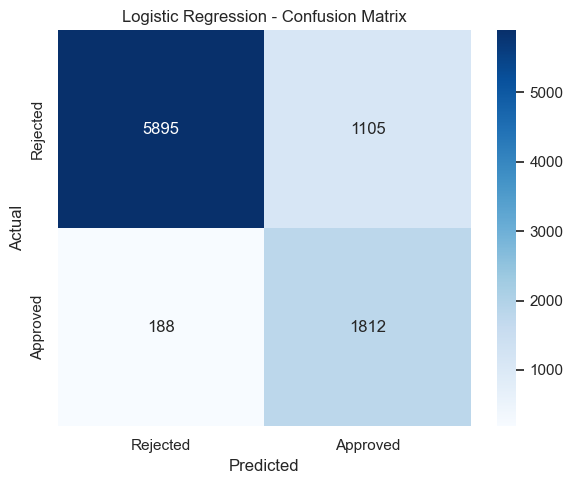

In [6]:
# Evaluate on test set
lr_metrics, lr_y_pred, lr_y_prob = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
print_test_results(lr_metrics, y_test, lr_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test, lr_y_pred, "Logistic Regression", ax)
plt.tight_layout()
plt.show()


## 4. Random Forest

An ensemble of decision trees that reduces overfitting through bagging and random feature selection.

**Characteristics:**
- Handles non-linear relationships well
- Robust to outliers
- Provides feature importance rankings
- Scale-invariant (uses unscaled data)

**Data Used:** Unscaled training data (`X_train_unscaled_res`)


In [7]:
# Initialize Random Forest with default parameters
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# Cross-validation on training data (UNSCALED)
print("Running 5-fold cross-validation...")
rf_cv_results = cross_validate_model(rf_model, X_train_unscaled_res, y_train_res)
print_cv_results(rf_cv_results, "Random Forest")

# Train on full training set
rf_model.fit(X_train_unscaled_res, y_train_res)
print("\nModel trained on full training set.")


Running 5-fold cross-validation...

Random Forest - Cross-Validation Results (5-fold)
  Accuracy:  0.9422 ± 0.0024
  Precision: 0.9250 ± 0.0030
  Recall:    0.9625 ± 0.0028
  F1-Score:  0.9434 ± 0.0023
  ROC-AUC:   0.9886 ± 0.0011

Model trained on full training set.



Random Forest - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.95      0.92      0.93      7000
    Approved       0.74      0.84      0.79      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.88      0.86      9000
weighted avg       0.91      0.90      0.90      9000

ROC-AUC Score: 0.9642


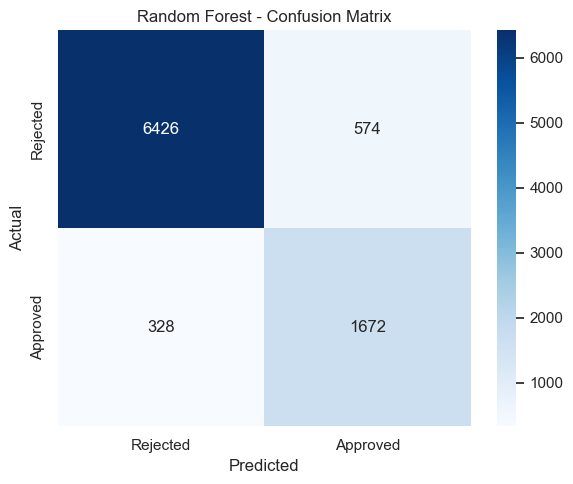

In [20]:
# Evaluate on test set (UNSCALED)
rf_metrics, rf_y_pred, rf_y_prob = evaluate_model(rf_model, X_test_unscaled, y_test, "Random Forest")
print_test_results(rf_metrics, y_test, rf_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test, rf_y_pred, "Random Forest", ax)
plt.tight_layout()
plt.show()


Top 10 Most Important Features:
                       feature  importance
previous_loan_defaults_on_file    0.349930
                 loan_int_rate    0.132796
           loan_percent_income    0.096668
                    log_income    0.059679
                 person_income    0.058361
         person_home_ownership    0.040902
                   loan_intent    0.038195
          income_per_household    0.033653
                     loan_amnt    0.029080
                 log_loan_amnt    0.029034


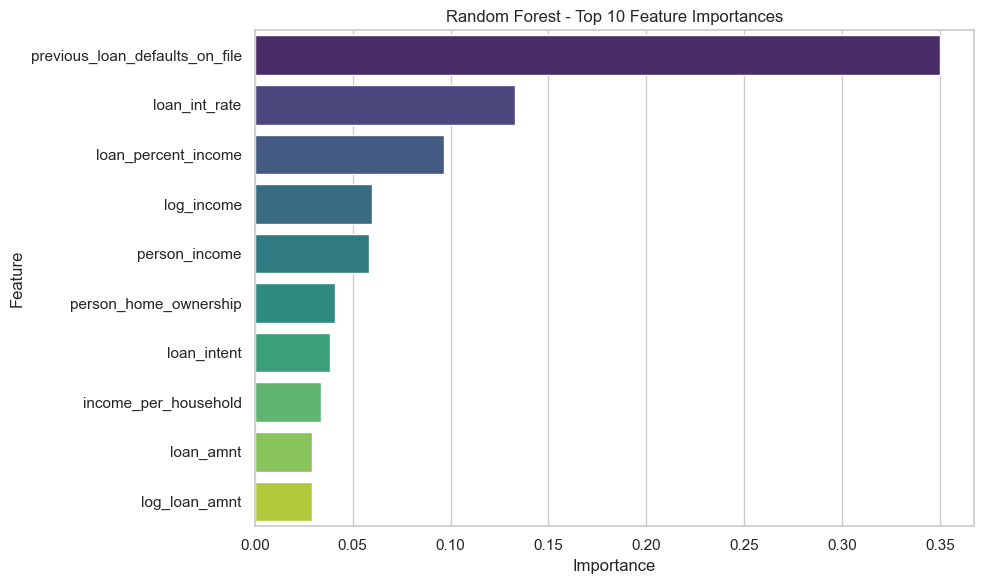


Figure saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/figures/rf_feature_importance.png


In [9]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_10 = feature_importance.head(10)
sns.barplot(data=top_10, x='importance', y='feature', palette='viridis', ax=ax)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Random Forest - Top 10 Feature Importances')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nFigure saved to: {FIGURES_DIR / 'rf_feature_importance.png'}")


## 5. Artificial Neural Network (MLPClassifier)

A multi-layer perceptron that learns non-linear decision boundaries through backpropagation.

**Characteristics:**
- Can capture complex, non-linear patterns
- Flexible architecture (layers, neurons)
- Sensitive to feature scaling
- May require more tuning for optimal performance

**Data Used:** Scaled training data (`X_train_scaled_res`)

**Note:** Using sklearn's `MLPClassifier` with default architecture (single hidden layer of 100 neurons).


In [10]:
# Initialize MLPClassifier with default parameters
ann_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=500)

# Cross-validation on training data
print("Running 5-fold cross-validation...")
print("(This may take a few minutes...)")
ann_cv_results = cross_validate_model(ann_model, X_train_scaled_res, y_train_res)
print_cv_results(ann_cv_results, "MLPClassifier (ANN)")

# Train on full training set
ann_model.fit(X_train_scaled_res, y_train_res)
print(f"\nModel trained on full training set.")
print(f"Training converged in {ann_model.n_iter_} iterations.")


Running 5-fold cross-validation...
(This may take a few minutes...)

MLPClassifier (ANN) - Cross-Validation Results (5-fold)
  Accuracy:  0.9139 ± 0.0051
  Precision: 0.8973 ± 0.0057
  Recall:    0.9348 ± 0.0112
  F1-Score:  0.9156 ± 0.0053
  ROC-AUC:   0.9737 ± 0.0022

Model trained on full training set.
Training converged in 287 iterations.



MLPClassifier (ANN) - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.96      0.88      0.91      7000
    Approved       0.67      0.86      0.75      2000

    accuracy                           0.87      9000
   macro avg       0.81      0.87      0.83      9000
weighted avg       0.89      0.87      0.88      9000

ROC-AUC Score: 0.9551


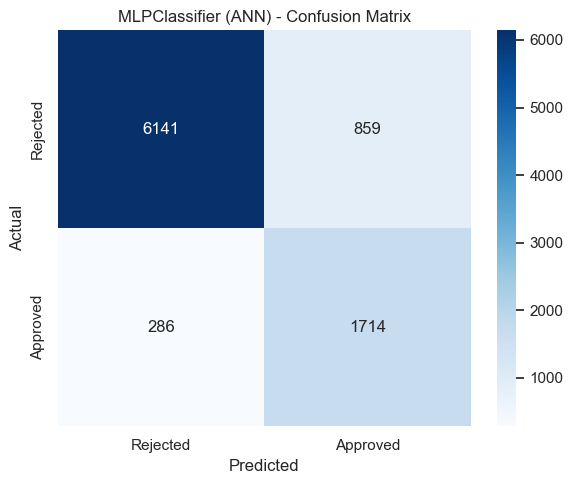

In [11]:
# Evaluate on test set
ann_metrics, ann_y_pred, ann_y_prob = evaluate_model(ann_model, X_test_scaled, y_test, "MLPClassifier (ANN)")
print_test_results(ann_metrics, y_test, ann_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test, ann_y_pred, "MLPClassifier (ANN)", ax)
plt.tight_layout()
plt.show()


## 6. Model Comparison

Compare all three models side-by-side using test set performance metrics.


In [12]:
# Combine all metrics into a comparison table
all_metrics = pd.DataFrame([lr_metrics, rf_metrics, ann_metrics])
all_metrics = all_metrics.set_index('model')

# Add CV results
cv_data = {
    'Logistic Regression': lr_cv_results,
    'Random Forest': rf_cv_results,
    'MLPClassifier (ANN)': ann_cv_results
}

for model_name, cv_results in cv_data.items():
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        all_metrics.loc[model_name, f'cv_{metric}_mean'] = cv_results[f'{metric}_mean']
        all_metrics.loc[model_name, f'cv_{metric}_std'] = cv_results[f'{metric}_std']

print("=" * 70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 70)
print(all_metrics[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4).to_string())

# Save to CSV
all_metrics.to_csv(RESULTS_DIR / 'metrics.csv')
print(f"\nMetrics saved to: {RESULTS_DIR / 'metrics.csv'}")


MODEL COMPARISON - TEST SET PERFORMANCE
                     accuracy  precision  recall      f1  roc_auc
model                                                            
Logistic Regression    0.8563     0.6212   0.906  0.7370   0.9485
Random Forest          0.8998     0.7444   0.836  0.7876   0.9642
MLPClassifier (ANN)    0.8728     0.6661   0.857  0.7496   0.9551

Metrics saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/metrics.csv


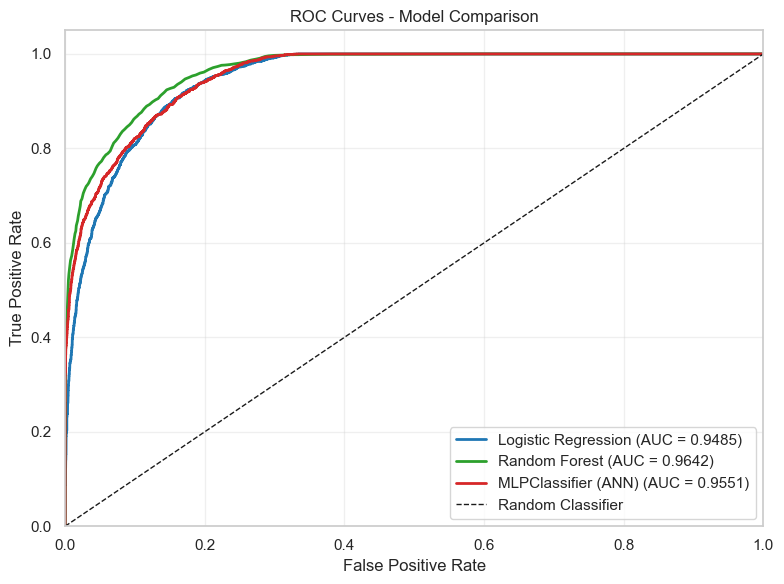


Figure saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/figures/roc_curves.png


In [13]:
# Plot ROC curves for all models
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate ROC curves
models_roc = [
    ('Logistic Regression', lr_y_prob, lr_metrics['roc_auc']),
    ('Random Forest', rf_y_prob, rf_metrics['roc_auc']),
    ('MLPClassifier (ANN)', ann_y_prob, ann_metrics['roc_auc'])
]

colors = ['#1f77b4', '#2ca02c', '#d62728']

for (name, y_prob, auc_score), color in zip(models_roc, colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_score:.4f})')

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Model Comparison')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nFigure saved to: {FIGURES_DIR / 'roc_curves.png'}")


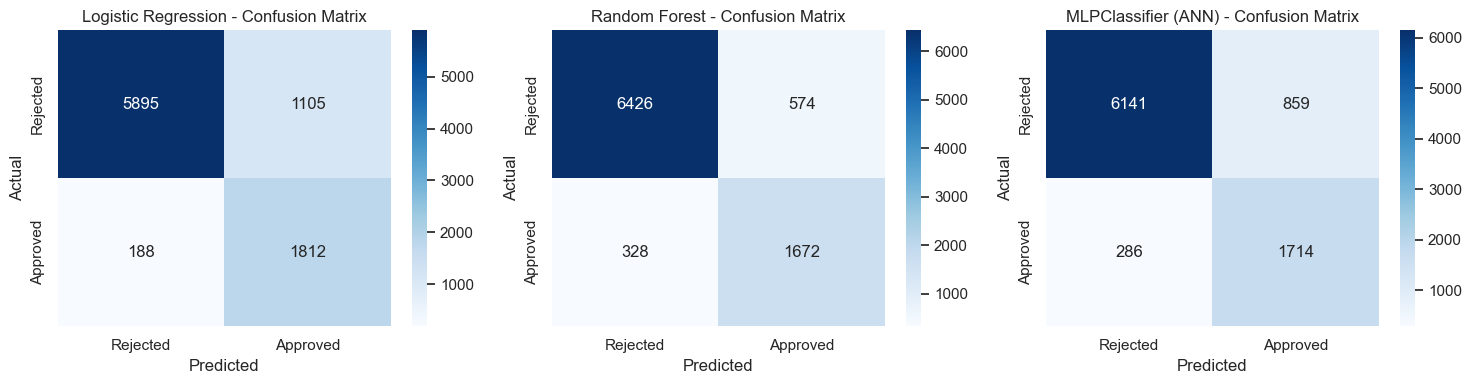


Figure saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/figures/confusion_matrices.png


In [14]:
# All confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

predictions = [
    ('Logistic Regression', lr_y_pred),
    ('Random Forest', rf_y_pred),
    ('MLPClassifier (ANN)', ann_y_pred)
]

for ax, (name, y_pred) in zip(axes, predictions):
    plot_confusion_matrix(y_test, y_pred, name, ax)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nFigure saved to: {FIGURES_DIR / 'confusion_matrices.png'}")


## 7. Save Trained Models

Save all models to the `models/` directory for use in Phase 4 (optimization) and deployment.


In [15]:
# Save all trained models
models_to_save = {
    'logistic_regression.pkl': lr_model,
    'random_forest.pkl': rf_model,
    'ann_model.pkl': ann_model
}

for filename, model in models_to_save.items():
    filepath = MODELS_DIR / filename
    joblib.dump(model, filepath)
    print(f"Saved: {filepath}")

# Verify models can be loaded
print("\nVerifying saved models...")
for filename in models_to_save.keys():
    loaded_model = joblib.load(MODELS_DIR / filename)
    print(f"  ✓ {filename} loaded successfully")

print("\nAll models saved and verified.")


Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/logistic_regression.pkl
Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/random_forest.pkl
Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/ann_model.pkl

Verifying saved models...
  ✓ logistic_regression.pkl loaded successfully
  ✓ random_forest.pkl loaded successfully
  ✓ ann_model.pkl loaded successfully

All models saved and verified.


## 8. Summary and Analysis

### 8.1 Bias-Variance Tradeoff Analysis

Comparing cross-validation (training) performance with test set performance helps identify overfitting or underfitting:


In [16]:
# Bias-Variance Analysis: Compare CV vs Test performance
print("=" * 70)
print("BIAS-VARIANCE ANALYSIS")
print("=" * 70)
print("\nComparing Cross-Validation (CV) vs Test Set Performance:")
print("-" * 70)

models_analysis = [
    ('Logistic Regression', lr_cv_results, lr_metrics),
    ('Random Forest', rf_cv_results, rf_metrics),
    ('MLPClassifier (ANN)', ann_cv_results, ann_metrics)
]

for name, cv_results, test_metrics in models_analysis:
    cv_acc = cv_results['accuracy_mean']
    test_acc = test_metrics['accuracy']
    cv_auc = cv_results['roc_auc_mean']
    test_auc = test_metrics['roc_auc']
    
    acc_diff = test_acc - cv_acc
    auc_diff = test_auc - cv_auc
    
    print(f"\n{name}:")
    print(f"  Accuracy:  CV={cv_acc:.4f}  →  Test={test_acc:.4f}  (Δ={acc_diff:+.4f})")
    print(f"  ROC-AUC:   CV={cv_auc:.4f}  →  Test={test_auc:.4f}  (Δ={auc_diff:+.4f})")
    
    # Interpret
    if abs(acc_diff) < 0.02 and abs(auc_diff) < 0.02:
        print("  → Good generalization (low variance)")
    elif acc_diff < -0.02 or auc_diff < -0.02:
        print("  → Possible overfitting (high variance)")
    else:
        print("  → Test performance better than CV (unusual, check data)")


BIAS-VARIANCE ANALYSIS

Comparing Cross-Validation (CV) vs Test Set Performance:
----------------------------------------------------------------------

Logistic Regression:
  Accuracy:  CV=0.8863  →  Test=0.8563  (Δ=-0.0300)
  ROC-AUC:   CV=0.9558  →  Test=0.9485  (Δ=-0.0073)
  → Possible overfitting (high variance)

Random Forest:
  Accuracy:  CV=0.9422  →  Test=0.8998  (Δ=-0.0424)
  ROC-AUC:   CV=0.9886  →  Test=0.9642  (Δ=-0.0244)
  → Possible overfitting (high variance)

MLPClassifier (ANN):
  Accuracy:  CV=0.9139  →  Test=0.8728  (Δ=-0.0411)
  ROC-AUC:   CV=0.9737  →  Test=0.9551  (Δ=-0.0185)
  → Possible overfitting (high variance)


In [17]:
# Identify best baseline model
best_model_name = all_metrics['roc_auc'].idxmax()
best_roc_auc = all_metrics.loc[best_model_name, 'roc_auc']

print("\n" + "=" * 70)
print("BASELINE MODEL RANKING (by ROC-AUC)")
print("=" * 70)
ranking = all_metrics[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].sort_values('roc_auc', ascending=False)
print(ranking.round(4).to_string())
print(f"\n★ Best Baseline Model: {best_model_name} (ROC-AUC = {best_roc_auc:.4f})")



BASELINE MODEL RANKING (by ROC-AUC)
                     accuracy  precision  recall      f1  roc_auc
model                                                            
Random Forest          0.8998     0.7444   0.836  0.7876   0.9642
MLPClassifier (ANN)    0.8728     0.6661   0.857  0.7496   0.9551
Logistic Regression    0.8563     0.6212   0.906  0.7370   0.9485

★ Best Baseline Model: Random Forest (ROC-AUC = 0.9642)


### 8.2 Key Findings

**Model Characteristics:**

| Model | Strengths | Weaknesses |
|-------|-----------|------------|
| **Logistic Regression** | Fast, interpretable, good baseline | Limited to linear decision boundaries |
| **Random Forest** | Handles non-linearity, provides feature importance | Can overfit, less interpretable |
| **MLPClassifier** | Captures complex patterns | Slower training, sensitive to hyperparameters |

### 8.3 Recommendations for Phase 4 (Hyperparameter Optimization)

**Logistic Regression:**
- Tune regularization strength (`C`)
- Try different penalties (`l1`, `l2`, `elasticnet`)
- Experiment with different solvers

**Random Forest:**
- Tune `n_estimators` (number of trees)
- Tune `max_depth` to control overfitting
- Tune `min_samples_split` and `min_samples_leaf`
- Consider `max_features` for feature subsampling

**MLPClassifier:**
- Tune `hidden_layer_sizes` (architecture)
- Tune `alpha` (L2 regularization)
- Tune `learning_rate_init`
- Try different activation functions (`relu`, `tanh`)
- Consider `early_stopping=True` with validation split


In [18]:
# Final Summary
print("=" * 70)
print("PHASE 3 COMPLETE - MODEL TRAINING SUMMARY")
print("=" * 70)

print("\n📊 MODELS TRAINED:")
print(f"   • Logistic Regression (baseline linear model)")
print(f"   • Random Forest (ensemble of decision trees)")
print(f"   • MLPClassifier (artificial neural network)")

print("\n📈 EVALUATION METRICS:")
print(f"   • 5-fold Stratified Cross-Validation on training data")
print(f"   • Test set evaluation on {len(y_test):,} samples (original class distribution)")

print("\n💾 SAVED ARTIFACTS:")
print(f"   • models/logistic_regression.pkl")
print(f"   • models/random_forest.pkl")
print(f"   • models/ann_model.pkl")
print(f"   • results/metrics.csv")
print(f"   • results/figures/roc_curves.png")
print(f"   • results/figures/rf_feature_importance.png")
print(f"   • results/figures/confusion_matrices.png")

print("\n🎯 NEXT STEPS:")
print(f"   • Phase 4: Hyperparameter optimization using GridSearchCV/RandomizedSearchCV")
print(f"   • Focus on improving {best_model_name} (current best)")
print(f"   • Explore regularization to reduce overfitting if observed")

print("\n" + "=" * 70)
print("Ready for Phase 4: Model Optimization")
print("=" * 70)


PHASE 3 COMPLETE - MODEL TRAINING SUMMARY

📊 MODELS TRAINED:
   • Logistic Regression (baseline linear model)
   • Random Forest (ensemble of decision trees)
   • MLPClassifier (artificial neural network)

📈 EVALUATION METRICS:
   • 5-fold Stratified Cross-Validation on training data
   • Test set evaluation on 9,000 samples (original class distribution)

💾 SAVED ARTIFACTS:
   • models/logistic_regression.pkl
   • models/random_forest.pkl
   • models/ann_model.pkl
   • results/metrics.csv
   • results/figures/roc_curves.png
   • results/figures/rf_feature_importance.png
   • results/figures/confusion_matrices.png

🎯 NEXT STEPS:
   • Phase 4: Hyperparameter optimization using GridSearchCV/RandomizedSearchCV
   • Focus on improving Random Forest (current best)
   • Explore regularization to reduce overfitting if observed

Ready for Phase 4: Model Optimization
